#  Transfer Learning on STL-10 Dataset

## Introduction

Convolutional Neural Networks have become the model of choice for image classification problem in the recent years due to it stllart performance in various image recognition competitions. Since AlexNet was conceived in 2012 by Hilton et al. many new CNN architectures like VGG, ResNet, GoolgeNet, latest being DenseNet, have been introduced. In this exploration of STL-10 dataset, I tried some of these well known architectures and present the results. After evaluating deep learning librairis like Keras, Tensorflow and PyTorch, I chose PyTorch for its flexibility and ease of use when using pre-trained models. I find that PyTorch lends itself well for experimentation and research. It has out-of-the box support for loading standard image data sets and training them on well known CNN architectures.

Training was done on an AWS p2.xlarge instance which has one NVIDIA K80 GPU with 12 GiB Memory and 2,496 parallel processing cores.

STL 10 dataset contains 5000 training training, 8000 test and 100,000 unlabeled examples belonging to 10 categories. For this exploration, only labeled data is being utilized.  

STL-10 dataset can be found here: https://cs.stanford.edu/~acoates/stl10/


## Imports

In [71]:
import numpy as np
import torch
import torch.optim as optim
from torch import nn
from torch.autograd import Variable

import torchvision
import torchvision.models as models
import torch.utils.model_zoo as model_zoo
import torchvision.transforms as transforms
from torchvision import datasets

from torch.utils.data import sampler
from torch.utils.data import DataLoader
import torchvision.datasets as dset

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image

import time

use_gpu = torch.cuda.is_available()           
torch.manual_seed(233)
pass

In [34]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

def get_data(batch_size):
    resize=(224,224)
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomSizedCrop(max(resize)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN,IMAGENET_STD)
        ]),
        'test': transforms.Compose([
            transforms.Scale(int(max(resize)/224*256)),
            transforms.CenterCrop(max(resize)),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD) # ImageNet mean and SD
        ]),
    }

    data_dir = 'stl10_binary'
    dsets = {x: datasets.STL10(root=data_dir, split=x, transform=data_transforms[x], 
                               download=False)
             for x in ['train', 'test']}
    dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=batch_size,
                                                   shuffle=True)
                    for x in ['train', 'test']}
    dset_sizes = {x: len(dsets[x]) for x in ['train', 'test']}
    dset_classes = dsets['train'].classes
    
    return dset_loaders, dset_sizes, dset_classes

batch_size = 4 
dset_loaders, dset_sizes, dset_classes = get_data(batch_size)   
num_classes = len(dset_classes)


class_indices = {}
class_indices_list = [] #used later for confusion matrix
with open("./stl10_binary/class_names.txt") as f:
    label_number = 1
    for line in f:
        class_indices[label_number] = line.strip()
        class_indices_list.append(line.strip())
        label_number += 1

print('Dataset Size :', dset_sizes)
print('Dataset Classes:', dset_classes)

Dataset Size : {'train': 5000, 'test': 8000}
Dataset Classes: ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


## Print few images from the batches

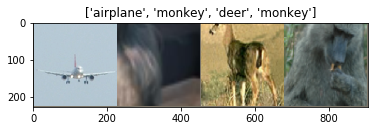

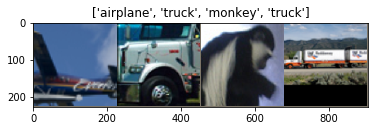

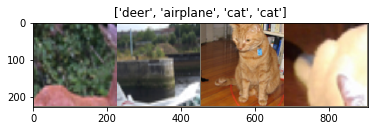

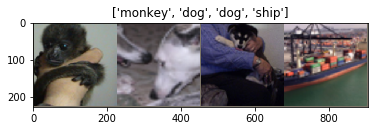

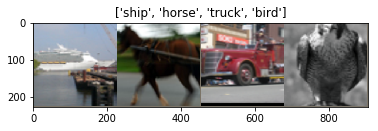

In [17]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(IMAGENET_MEAN)
    std = np.array(IMAGENET_STD)
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    plt.show()

#Print a few batches

for _ in range(5):
    # Get a batch of training data
    inputs, classes = next(iter(dset_loaders['train']))
    
    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs)

    imshow(out, title=[dset_classes[x] for x in classes])


## Model Selection

Dataset was trained and evaluated with popular CNN architectures. Results are summarzied below. Models were trained in thee modes : 'shallow' - where only the final classifier (dense) layer is trained, 'deep' - all the layers are trained with weights initialized from pre-trained models, 'from scratch' - training all layers from scratch without any transfer learning.

From the results below we can see VGG 19 and DenseNet perform the best. These models are chosen for further exploration. It is worth noting that VGG, which is a much simpler model, performs as well as DenseNet. 


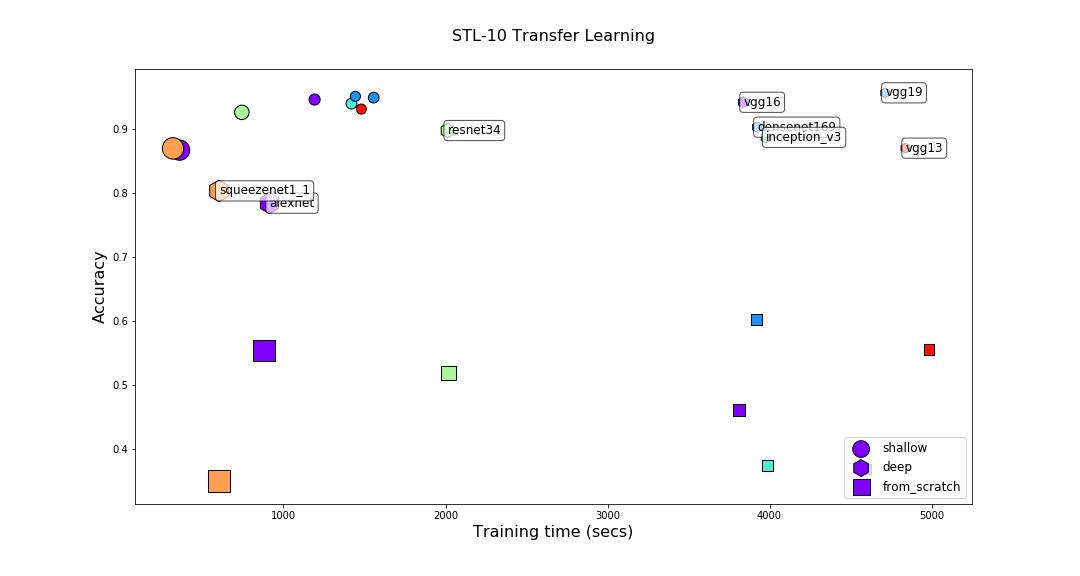

In [18]:
Image("./STL-10_transfer_learning.png")

In [19]:
model_summary_df = pd.read_csv('stl10_all.csv')
model_summary_df.sort_values(['accuracy', 'training_time'], ascending=False)

,variables_optimized,params_optimized,training_time,training_loss,accuracy,eval_time,name,retrained,shallow_retrain
23,38,139611210,4713.648551,0.228308,0.956750,158.990005,vgg19,True,False
21,2,40970,1443.758696,0.348962,0.951250,155.863928,vgg19,True,True
1,2,16650,1556.649786,0.735394,0.949250,140.075941,densenet169,True,True
18,2,40970,1191.837044,0.344017,0.946250,129.202540,vgg16,True,True
20,32,134301514,3838.207222,0.252448,0.942000,128.905066,vgg16,True,False
2,4,28180,1419.664638,2.061781,0.939875,134.450917,inception_v3,True,True
5,2,40970,1480.454847,0.705688,0.931375,158.312052,vgg13,True,True
3,2,5130,742.990186,0.722219,0.926250,75.772080,resnet34,True,True
13,508,12501130,3923.994528,0.548834,0.903125,140.654612,densenet169,True,False
15,110,21289802,2012.368405,0.538926,0.897875,75.930281,resnet34,True,False


## Fine tuning VGG

In [69]:
#Code adopted from PyTorch examples

def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=25, phases=['train', 'test']):
    since = time.time()

    best_model = model
    best_acc = 0.0

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in phases: 
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dset_loaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), \
                        Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects / dset_sizes[phase]

            print('Epoch {}/{} {} Loss: {:.4f} Acc: {:.4f}'.format(epoch, num_epochs - 1, 
                                                            phase, epoch_loss, epoch_acc))

            time_elapsed = time.time() - since
            print('Time elapsed {:.0f}m {:.0f}s'.format(
                            time_elapsed // 60, time_elapsed % 60))
    
            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return best_model

def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer
    
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dset_loaders['test']):
        inputs, labels = data
        if use_gpu:
            inputs = Variable(inputs.cuda())
        else:
            inputs = Variable(inputs)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        #plot some predictions
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(dset_classes[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return


In [21]:
#create and print VGG model
vgg19_model = models.vgg19(pretrained=True)
print(vgg19_model)

VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU (inplace)
    (18): MaxPool2d (size=(

## Freeze all the layers except the final fully connected layer in the classifier

In [12]:
for param in vgg19_model.parameters():
    vgg19_model.requires_grad = False

vgg19_model.classifier[6].out_features = num_classes # 10

for param in vgg19_model.classifier[6].parameters():
    vgg19_model.requires_grad = True

Note : For this and all experiements that follow, only 5 epocs are run due to time and resource constrains.

In [72]:
if use_gpu:
    vgg19_model = vgg19_model.cuda()

loss_function = nn.CrossEntropyLoss()

#only last fully connected layer is trained
optimizer = optim.SGD(vgg19_model.classifier[6].parameters(), lr=0.001, momentum=0.9)

model_conv = train_model(vgg19_model, loss_function, optimizer,
                         exp_lr_scheduler, num_epochs=5, phases=['train'])

Epoch 0/4 train Loss: 0.0666 Acc: 0.9096
Time elapsed 7m 48s

Epoch 1/4 train Loss: 0.0641 Acc: 0.9108
Time elapsed 15m 37s

Epoch 2/4 train Loss: 0.0611 Acc: 0.9128
Time elapsed 23m 26s

Epoch 3/4 train Loss: 0.0582 Acc: 0.9164
Time elapsed 31m 14s

Epoch 4/4 train Loss: 0.0612 Acc: 0.9130
Time elapsed 39m 3s

Training complete in 39m 3s
Best val Acc: 0.000000


## Change dropout to 0.2 and train all layers in the classifier

In [22]:
vgg19_model.classifier[2].p = 0.2
vgg19_model.classifier[5].p = 0.2

for param in vgg19_model.classifier.parameters():
    vgg19_model.requires_grad = True
if use_gpu:
    vgg19_model = vgg19_model.cuda()

loss_function = nn.CrossEntropyLoss()

#all layers in the classifier are trained
optimizer = optim.SGD(vgg19_model.classifier.parameters(), lr=0.001, momentum=0.9)

vgg19_do_model = train_model(vgg19_model, loss_function, optimizer,
                         exp_lr_scheduler, num_epochs=5, phases=['train'])

Epoch 0/4 train Loss: 0.1939 Acc: 0.7926
Time elapsed 8m 22s

Epoch 1/4 train Loss: 0.1096 Acc: 0.8560
Time elapsed 16m 43s

Epoch 2/4 train Loss: 0.0921 Acc: 0.8756
Time elapsed 25m 5s

Epoch 3/4 train Loss: 0.0910 Acc: 0.8766
Time elapsed 33m 27s

Epoch 4/4 train Loss: 0.0856 Acc: 0.8846
Time elapsed 41m 48s

Training complete in 41m 48s
Best val Acc: 0.000000


## DenseNet exploration

In [7]:
densenet161_model = models.densenet161(pretrained=True)
print(densenet161_model)

DenseNet (
  (features): Sequential (
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
    (relu0): ReLU (inplace)
    (pool0): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (denseblock1): _DenseBlock (
      (denselayer1): _DenseLayer (
        (norm.1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
        (relu.1): ReLU (inplace)
        (conv.1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm.2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True)
        (relu.2): ReLU (inplace)
        (conv.2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer (
        (norm.1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True)
        (relu.1): ReLU (inplace)
        (conv.1): Conv2d(144, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
    

## Freeze all the layers and train only the classifier

In [8]:
for param in densenet161_model.parameters():
    densenet161_model.requires_grad = False

densenet161_model.classifier.out_features = num_classes # 10

for param in densenet161_model.classifier.parameters():
    densenet161_model.requires_grad = True

In [9]:
if use_gpu:
    densenet161_model = densenet161_model.cuda()

loss_function = nn.CrossEntropyLoss()

#only last fully connected layer is trained
optimizer = optim.SGD(densenet161_model.classifier.parameters(), lr=0.001, momentum=0.9)

model_conv = train_model(densenet161_model, loss_function, optimizer,
                         exp_lr_scheduler, num_epochs=5, phases=['train']) 

Epoch 0/4
----------
LR is set to 0.001
train Loss: 0.3249 Acc: 0.6032
Time elapsed 7m 10s

Epoch 1/4
----------
train Loss: 0.1994 Acc: 0.7470
Time elapsed 14m 20s

Epoch 2/4
----------
train Loss: 0.1773 Acc: 0.7680
Time elapsed 21m 28s

Epoch 3/4
----------
train Loss: 0.1696 Acc: 0.7872
Time elapsed 28m 36s

Epoch 4/4
----------
train Loss: 0.1765 Acc: 0.7794
Time elapsed 35m 45s

Training complete in 35m 45s
Best val Acc: 0.000000


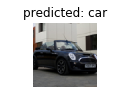

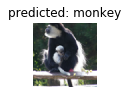

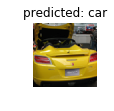

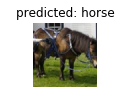

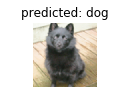

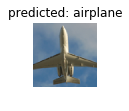

In [68]:
visualize_model(vgg19_do_model, num_images=6)

## Conclusion and Future work 

We explored the effectiveness of transfer learning with STL-10 dataset using well known CNN architectures. Re-training just the classification layer proves to be most effective in terms of accuracy/cost compared to re-training all the layers from pre-trained weights or from scratch. We find simple models like VGG can be extremely effective at image classification when limited data is available if transfer learning is used.

The following aspects can be explored further to achieve better results :
- Data Augmentation : Various data augmentation methods like flipping, color jitter, cutouts, etc. can be added
- Initialization: When training from scratch, Xavier or He initialization methods can be tried
- Regularization : Try additional dropout values, batch normalization, [shake-shake regularization](https://arxiv.org/abs/1705.07485) etc. can be tried
- Optimization: Different learning rates, RMSProp and Adam optimizer can be used
- Ensemble : Use the top 5 models and ensemble the results
